In [1]:
from unityagents import UnityEnvironment
# from mlagents_envs.environment import UnityEnvironment
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# f = 'Reacher_Windows'
f = 'Reacher_Windows_20'
# f = 'Reacher_Linux'
# f = 'Reacher_Linux_NoVis'
# f = 'Reacher_Linux_20'
# f = 'Reacher_Linux_NoVis_20'
no_graphics = False
env = UnityEnvironment(file_name='{}/Reacher'.format(f), seed=1,no_graphics=no_graphics, worker_id=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


## Brains

In [4]:
def brain(brain_name,agent,config,env, it=0):
    n_episodes = config.eval_episodes # 2000, 
    max_t = config.max_steps # 1500, 
    # eps_start=1.0, 
    # eps_end=0.01, 
    # eps_decay=0.995
    window = getattr(config, 'scores_window', 100)
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=window)  # last 100 scores
    # eps = eps_start                    # initialize epsilon

    pritty = getattr(config, 'pritty_fields', {})
    st = ''
    for k in config.update_fields:
        v = getattr(config, k)
        if k in pritty:
            k = pritty[k]
        if float(v).is_integer():
            st += '{}:{}\t'.format(k,v)
        else:
            st += '{}:{:.6f}\t'.format(k,v)
    print('\rStart[{}]\t{}'.format(it,st), flush = True)
#     , end=""

    win_mean = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        
        score = 0
        for t in range(max_t):
            action = agent.act(state) # eps
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
    
            agent.step(state, action, reward, next_state, done)
        
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        win_mean = np.mean(scores_window)
        # eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\t{} a-Average Score: {:.2f}'.format(i_episode,st,win_mean), end="")
        if i_episode % window == 0:
            # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print('\rEpisode[{}] {}\t{} a-Average Score: {:.2f}'.format(it, i_episode,st,win_mean), flush = True)
    
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment[{}] solved in {:d} episodes!\t{} Average Score: {:.2f}'.format(it,i_episode-100,st, win_mean), flush = True)
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return (scores, win_mean)

In [5]:
def brain_multy(brain_name,agent,config,env, it=0):
    number = config.num_workers
    n_episodes = config.eval_episodes # 2000, 
    max_t = config.max_steps # 1500, 
    window = getattr(config, 'scores_window', 100)
    
    scores = []                        # list containing scores from each episode
    scores_window = []  # last 100 scores
    
    for i in range(number):
#         scores.append([])
        scores_window.append(deque(maxlen=window))
    
    # eps = eps_start                    # initialize epsilon

    pritty = getattr(config, 'pritty_fields', {})
    st = ''
    for k in config.update_fields:
        v = getattr(config, k)
        if k in pritty:
            k = pritty[k]
        if float(v).is_integer():
            st += '{}:{}\t'.format(k,v)
        else:
            st += '{}:{:.6f}\t'.format(k,v)
    print('\rStart[{}]\t{}'.format(it,st), flush = True)
#     , end=""

#     next_states, rewards, terminals, info
    def step_fn(actions):
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        next_states = env_info.vector_observations   # get the next state
        rewards = env_info.rewards                   # get the reward
        dones = env_info.local_done                  # see if episode has finished
        dones = np.asarray(dones, dtype=np.int32)
        return (next_states,rewards,dones,env_info)
        
#     = lambda action: torch.optim.Adam(params, lr=config.actor_lr), #, weight_decay=config.weight_decay

    win_mean = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations
#         print("shape:{}".format(states.shape))
#         print(states)
#         break
        score = np.zeros(number)
        for t in range(max_t):
            
            states,rewards,dones = agent.learn(states,step_fn)         
            score = score + rewards
            if np.any(dones):
                break 
        for i in range(number):
            scores_window[i].append(score[i])       # save most recent score
        scores.append(np.mean(score))              # save most recent score
        
        win_mean = np.mean(scores_window)
        # eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\t{} a-Average Score: {:.2f}'.format(i_episode,st,win_mean), end="")
        if i_episode % window == 0:
            # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            print('\rEpisode[{}] {}\t{} a-Average Score: {:.2f}'.format(it, i_episode,st,win_mean), flush = True)
    
        if win_mean>=30.0:
            print('\nEnvironment[{}] solved in {:d} episodes!\t{} Average Score: {:.2f}'.format(it,i_episode-window,st, win_mean), flush = True)
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return (scores, win_mean)

## Strategies

In [6]:
def initConf_ddpg(state_size,action_size):
    select_device(0)

    config = Config()

    config.update_fields = ['fc1','fc2','fc3','weight_decay','actor_lr','critic_lr','weight_decay_act','target_network_mix','discount','gradient_clip']

    # config.merge(kwargs)
    config.device = Config.DEVICE
    print("config.device:{}".format(config.device))
    
    config.seed = 0    

    config.fc1 = 300
    config.fc2 = 200
    config.fc3 = 100

    config.eval_episodes = 200
    config.max_steps = int(1e7)
    config.batch_size = 64
    
    config.gradient_clip = 5
    config.eval_interval = 4
    config.memory_size = int(1e6)            
    config.warm_up = config.batch_size

    # num_agents
    config.state_dim = state_size
    config.action_dim = action_size
    # 400, 300
    config.network_fn = lambda cfg: DeterministicActorCriticNet(
        cfg.state_dim, cfg.action_dim,
        actor_body=FCBody(cfg.state_dim, (cfg.fc1, cfg.fc2, cfg.fc3), gate=F.relu),
        critic_body=FCBody(cfg.state_dim + cfg.action_dim, (cfg.fc1, cfg.fc2, cfg.fc3), gate=F.relu),

        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=cfg.actor_lr, weight_decay=cfg.weight_decay_act),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=cfg.critic_lr, weight_decay=cfg.weight_decay))

    # self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)    
    config.replay_fn = lambda: UniformReplay(memory_size=config.memory_size, batch_size=config.batch_size)

    config.agent_fn = lambda conf: DDPGAg(conf)
    config.brain_fn = lambda cfg: brain(brain_name,cfg.agent_fn(cfg),cfg,env)

    config.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
        size=(config.action_dim,), std=LinearSchedule(0.2)) 
    return config

In [7]:
def initConf_td3(state_size,action_size):
    
    select_device(0)
    config = Config()

    config.update_fields = ['fc1','fc2','fc3','weight_decay','weight_decay_act','actor_lr','critic_lr','target_network_mix','discount','gradient_clip']
    
    config.fc1 = 300
    config.fc2 = 200
    config.fc3 = 100

    config.device = Config.DEVICE
    config.state_dim = state_size
    config.action_dim = action_size

    config.max_steps = int(1e7)
    config.eval_episodes = 100
    config.batch_size = 128

    config.eval_interval = int(1e4)
    config.memory_size=int(1e6)

    config.gradient_clip = 5
    config.weight_decay=0.012
    config.actor_lr = 1e-4
    config.critic_lr = 1e-4
    config.target_network_mix = 5e-3
    config.discount = 0.98

    config.td3_noise = 0.2
    config.td3_noise_clip = 0.5
    config.td3_delay = 2

    config.network_fn = lambda cfg: TD3Net(
        cfg.action_dim,
        actor_body_fn=lambda: FCBody(cfg.state_dim, (cfg.fc1, cfg.fc2, cfg.fc3), gate=F.relu),
        critic_body_fn=lambda: FCBody(cfg.state_dim + cfg.action_dim, (cfg.fc1, cfg.fc2, cfg.fc3), gate=F.relu),
        actor_opt_fn=lambda params: torch.optim.Adam(params, lr=cfg.actor_lr, weight_decay=cfg.weight_decay_act),
        critic_opt_fn=lambda params: torch.optim.Adam(params, lr=cfg.critic_lr,weight_decay=cfg.weight_decay))
    #     .to(config.device)

    replay_kwargs = dict(
        memory_size=config.memory_size,
        batch_size=config.batch_size,
    )

    config.replay_fn = lambda: ReplayWrapper(UniformReplay, replay_kwargs, async=False)
    config.random_process_fn = lambda: GaussianProcess(
        size=(config.action_dim,), std=LinearSchedule(0.1))

    config.warm_up = int(1e4)

    config.agent_fn = lambda conf: TD3Ag(conf)
    config.brain_fn = lambda cfg: brain(brain_name,cfg.agent_fn(cfg),cfg,env)
    
    return config

In [6]:
# from deep_rl import *
# from agent import *
# A2C
def a2c_feature(state_size,action_size,brain_name,env):
    config = Config()

    config.update_fields = ['rollout_length', 'lr', 'gae_tau', 'entropy_weight', 'discount','gradient_clip','use_gae']
    config.pritty_fields = {'rollout_length':'rout_L','gae_tau':'G_tau','entropy_weight':'e_W','use_gae':'G_use','gradient_clip':'Clip','discount':'G'}
    config.max_steps = int(2e7)

#     config.eval_interval = int(1e4)
    config.eval_episodes = 200
    config.batch_size = 128
#     config.memory_size=int(1e6)
    
    config.device = Config.DEVICE
    config.state_dim = state_size
    config.action_dim = action_size
    
    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 1.0
    config.entropy_weight = 0.01
    config.rollout_length = 10
    config.gradient_clip = 2
    config.lr = 0.0007

    config.num_workers = 20
    
    config.optimizer_fn = lambda params,cfg: torch.optim.RMSprop(params, lr=cfg.lr)
    config.network_fn = lambda cfg: GaussianActorCriticNet(
        cfg.state_dim, cfg.action_dim,
        actor_body=FCBody(cfg.state_dim), critic_body=FCBody(cfg.state_dim))
        
#     config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
#     config.network_fn = lambda: CategoricalActorCriticNet(
#         config.state_dim, config.action_dim, FCBody(config.state_dim, gate=F.tanh))
    
    config.storage_fn = lambda:  Storage(config.rollout_length)
    
    config.agent_fn = lambda cfg: A2CAg(cfg)
    config.brain_fn = lambda cfg: brain_multy(brain_name,cfg.agent_fn(cfg),cfg,env)
    
    return config

## Tuner

In [7]:
from unityagents import UnityEnvironment
# from mlagents_envs.environment import UnityEnvironment
import numpy as np
import pandas as pd
import torch

from time import sleep

from deep_rl import *
from agent import *
from hebo.design_space.design_space import DesignSpace
from hebo.optimizers.hebo import HEBO
from joblib import Parallel, delayed

import os
base_path = os.getcwd()


def tune(
    config : Config,
    space_cfg, 
    max_iter=10, 
    hebo_cfg = None,
    greater_is_better : bool = True,
    verbose  = True,
    first = [],
    **kwargs
    ):

    if hebo_cfg is None:
        hebo_cfg = {}
    space = DesignSpace().parse(space_cfg)
    opt   = HEBO(space, **hebo_cfg)
    
    scoresz = []
    first_index = 0
    for i in range(max_iter):
        if len(first) > first_index:
            hyp = first[first_index]
            first_index += 1
            details = {}
            for n,v in hyp.items():
                details[n] = [v]
            rec = pd.DataFrame(details)
        else:
            rec     = opt.suggest()
            hyp     = rec.iloc[0].to_dict()
        for k in config.update_fields:
#         for k in hyp:
            if space.paras[k].is_numeric and space.paras[k].is_discrete:
#                 hyp[k] = int(hyp[k])
                setattr(config, k, int(hyp[k]))
            else:
                setattr(config, k, hyp[k])

        scores,reward = config.brain_fn(config)
        # brain(brain_name,a,config,env)
        scoresz.append(scores)

        sign    = -1. if greater_is_better else 1.0
        opt.observe(rec, np.array([sign * reward]))
        if verbose:
            print('\rIter %d, best metric: %g' % (i, sign * opt.y.min()), flush = True, end="")
            
    best_id   = np.argmin(opt.y.reshape(-1))
    best_hyp  = opt.X.iloc[best_id]
    df_report = opt.X.copy()
    df_report['metric'] = sign * opt.y
    return best_hyp.to_dict(),scoresz[best_id]

In [9]:
def core_para(it, hyp, env = None):
    print("it:{} hyp:{}".format(it,hyp), flush = True)
    
    filename = os.path.join(base_path, '{}/Reacher'.format('Reacher_Windows'))
    
    if env is None:
        env = UnityEnvironment(file_name=filename, seed=0,no_graphics=False, worker_id=0+it)
    
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    states = env_info.vector_observations
    state_size = states.shape[1]

    config = initConf_ddpg(state_size,action_size)
    
    for k in config.update_fields:
        if space.paras[k].is_numeric and space.paras[k].is_discrete:
            setattr(config, k, int(hyp[k]))
        else:
            setattr(config, k, hyp[k])

    a = config.agent_fn(config)
    scores,reward = brain(brain_name,a,config,env,it=it)
    env.close()
    return (scores,reward)

def tune_para(
    space_cfg, 
    max_iter=10, 
    hebo_cfg = None,
    greater_is_better : bool = True,
    verbose  = True,
    **kwargs
    ):
    
    sign = -1. if greater_is_better else 1.0

    if hebo_cfg is None:
        hebo_cfg = {}
    space = DesignSpace().parse(space_cfg)
    opt   = HEBO(space, rand_sample = 1, **hebo_cfg)
    
#     envs = []
#     print("UnityEnvironment Start".format(), flush = True)
    
#     f = 'Reacher_Windows'
#     no_graphics = False
#     for i in range(1,3):
#         print("UnityEnvironment i:{}".format(i), flush = True)
#         done = False
#         failed = 0
#         while not done:
#             try:
#                 envs.append(UnityEnvironment(file_name='{}/Reacher'.format(f), seed=1,no_graphics=no_graphics, worker_id=0+i))
#                 done = True
#                 print("UnityEnvironment Done i:{}".format(i), flush = True)
#                 sleep(5)
#             except Exception as e:            
#                 print("it:{} UnityEnvironment failed:{}".format(i,e), flush = True)
#                 failed += 1
#                 if failed>5:
#                     done = True
#             return            
#     print("it:{} UnityEnvironment len envs:{}".format(i,len(envs)), flush = True)
    
    scoresz = []
    
    try:
    
        for i in range(max_iter):
            rec     = opt.suggest(n_suggestions=2)
    #         hyp     = rec.iloc[0].to_dict()
    #         verbose=100, pre_dispatch='1.5*n_jobs'
            outs = Parallel(n_jobs=2,verbose=100, prefer="processes")(delayed(core_para)(i,rc.to_dict()) for i,rc in enumerate(rec.iloc))
#         envs[i],

            outs
            if verbose:
                print('\routs:{}'.format(outs), flush = True)

            a = []
            for s,r in outs:
                a.append(sign * r)

            opt.observe(rec, np.array(a))
    #         opt.observe(rec, np.array([sign * reward]))
            if verbose:
                print('\nIter %d, best metric: %g' % (i, sign * opt.y.min()), flush = True, end="")
    except Exception as e:                
#         for env in envs:
#             env.close()
#         envs = []
        raise e
#     else:
#         for env in envs:
#             env.close()
#         envs = []
    
    best_id   = np.argmin(opt.y.reshape(-1))
    best_hyp  = opt.X.iloc[best_id]
    df_report = opt.X.copy()
    df_report['metric'] = sign * opt.y
#     if report:
#         return best_hyp.to_dict(), df_report
    return best_hyp.to_dict(),scoresz[best_id]

## Runners

In [15]:
select_device(-1)
space_cfg = [
        
        {'name' : 'fc1',             'type' : 'int', 'lb' : 300, 'ub' : 500, "step": 100},
        {'name' : 'fc2',             'type' : 'int', 'lb' : 200, 'ub' : 400, "step": 100},
        {'name' : 'fc3',             'type' : 'int', 'lb' : 100, 'ub' : 300, "step": 100},
    
        {'name' : 'gradient_clip',   'type' : 'int', 'lb' : 1.0, 'ub' : 10.0},
    
        {'name' : 'discount',        'type' : 'num', 'lb' : 0.7, 'ub' : 1.0},
    
        {'name' : 'actor_lr',        'type' : 'pow', 'lb' : 1e-6, 'ub' : 1e-2},
        {'name' : 'critic_lr',       'type' : 'pow', 'lb' : 1e-6, 'ub' : 1e-2},
        {'name' : 'weight_decay_act','type' : 'num', 'lb' : 0.0, 'ub' : 0.1},
        {'name' : 'weight_decay',    'type' : 'num', 'lb' : 0.0, 'ub' : 0.1},
    
        {'name' : 'target_network_mix',       'type' : 'pow', 'lb' : 1e-4, 'ub' : 1e-2},

#         {'name' : 'max_features',     'type' : 'cat', 'categories' : ['auto', 'sqrt', 'log2']},
#         {'name' : 'bootstrap',        'type' : 'bool'},
        ]

In [ ]:
# best,scores = tune_para(space_cfg)
# print('Best:{}'.format(best) , flush = True)

In [16]:
config = initConf_ddpg(state_size,action_size)
Config.DEVICE = torch.device('cpu')
config.device = Config.DEVICE
config.eval_episodes = 250
config.scores_window = 50
best,scores = tune(config, space_cfg, max_iter = 20)
print('\nBest:{}'.format(best) , flush = True)
# scores = brain(brain_name,agent,config,env)

config.device:cuda:0
Start[0]	fc1:300.000000	fc2:200.000000	fc3:100.000000	weight_decay:0.000000	actor_lr:0.000001	critic_lr:0.000001	weight_decay_act:0.000000	target_network_mix:0.010000	discount:0.700000	gradient_clip:1.000000	
Episode[0] 100	fc1:300.000000	fc2:200.000000	fc3:100.000000	weight_decay:0.000000	actor_lr:0.000001	critic_lr:0.000001	weight_decay_act:0.000000	target_network_mix:0.010000	discount:0.700000	gradient_clip:1.000000	 a-Average Score: 0.78
Start[0]	fc1:400.000000	fc2:300.000000	fc3:200.000000	weight_decay:0.050000	actor_lr:0.000100	critic_lr:0.000100	weight_decay_act:0.050000	target_network_mix:0.001000	discount:0.850000	gradient_clip:3.000000	
Episode[0] 100	fc1:400.000000	fc2:300.000000	fc3:200.000000	weight_decay:0.050000	actor_lr:0.000100	critic_lr:0.000100	weight_decay_act:0.050000	target_network_mix:0.001000	discount:0.850000	gradient_clip:3.000000	 a-Average Score: 0.39
Start[0]	fc1:450.000000	fc2:250.000000	fc3:150.000000	weight_decay:0.075000	actor_lr:0.

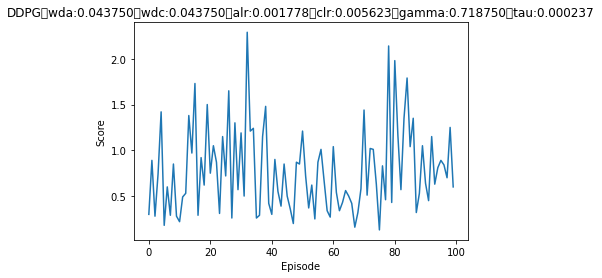

In [17]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title("DDPG\twda:{:.6f}\twdc:{:.6f}\talr:{:.6f}\tclr:{:.6f}\tgamma:{:.6f}\ttau:{:.6f}".format(
    config.weight_decay_act, # \twda:{:.6f}
    config.weight_decay,
    config.actor_lr,
    config.critic_lr,
    config.discount,
    config.target_network_mix))
plt.show()

In [16]:
config = initConf_td3(state_size,action_size)
Config.DEVICE = torch.device('cpu')
config.device = Config.DEVICE
config.eval_episodes = 100
best,scores = tune(config,space_cfg,max_iter = 1)
print('Best:{}'.format(best) , flush = True)    

Start[0]	fc1:300.000000	fc2:200.000000	fc3:100.000000	weight_decay:0.000000	weight_decay_act:0.000000	actor_lr:0.000001	critic_lr:0.000001	target_network_mix:0.010000	discount:0.700000	gradient_clip:1.000000	
Episode[0] 100	fc1:300.000000	fc2:200.000000	fc3:100.000000	weight_decay:0.000000	weight_decay_act:0.000000	actor_lr:0.000001	critic_lr:0.000001	target_network_mix:0.010000	discount:0.700000	gradient_clip:1.000000	 a-Average Score: 0.26
Iter 0, best metric: 0.2621Best:{'fc1': 300, 'fc2': 200, 'fc3': 100, 'gradient_clip': 1, 'discount': 0.7, 'actor_lr': 1.000000000000002e-06, 'critic_lr': 1.000000000000002e-06, 'weight_decay_act': 0.0, 'weight_decay': 0.0, 'target_network_mix': 0.01000000000000001}


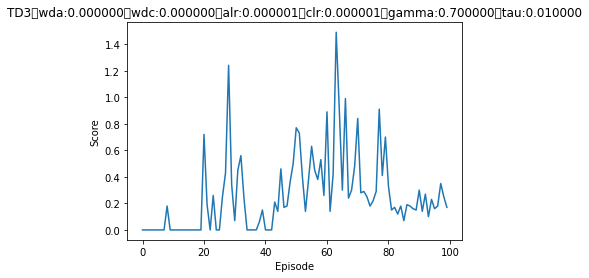

In [17]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title("TD3\twda:{:.6f}\twdc:{:.6f}\talr:{:.6f}\tclr:{:.6f}\tgamma:{:.6f}\ttau:{:.6f}".format(
    config.weight_decay_act,
    config.weight_decay,
    config.actor_lr,
    config.critic_lr,
    config.discount,
    config.target_network_mix))
plt.show()

In [9]:
env.close()

In [13]:
# from unityagents import UnityEnvironment
# # from mlagents_envs.environment import UnityEnvironment
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# %matplotlib inline

f = 'Reacher_Windows_20'
no_graphics = False
env = UnityEnvironment(file_name='{}/Reacher'.format(f), seed=1,no_graphics=no_graphics, worker_id=1)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

In [6]:
import tools as ts
from deep_rl import *
first = [
    {'rollout_length': 8,  'discount': 0.975120, 'gradient_clip': 7, 'lr': 0.000010, 'gae_tau': 0.996467, 'entropy_weight': 0.001504, 'use_gae': False},
    {'rollout_length': 10, 'discount': 0.9847894774762507, 'gradient_clip': 2, 'lr': 1.0071160478803324e-05, 'gae_tau': 0.9899540738644809, 'entropy_weight': 0.0011836478393662721, 'use_gae': True},
]
space_cfg = [
        {'name' : 'rollout_length',  'type' : 'int', 'lb' : 2, 'ub' : 20},    
        {'name' : 'discount',        'type' : 'num', 'lb' : 0.8, 'ub' : 1.0, 'step':0.01},
        {'name' : 'gradient_clip',   'type' : 'int', 'lb' : 1.0, 'ub' : 13.0},
        {'name' : 'lr',              'type' : 'pow', 'lb' : 0.000001, 'ub' : 0.001},
        {'name' : 'gae_tau',         'type' : 'num', 'lb' : 0.8, 'ub' : 1.0},
        {'name' : 'entropy_weight',  'type' : 'num', 'lb' : 0.0009, 'ub' : 0.02},
        {'name' : 'use_gae',         'type' : 'bool'},
    ]

In [5]:
config = ts.a2c_feature(state_size,action_size,brain_name,env)
agent = config.agent_fn(config)
torch.save(agent.network.state_dict(), 'checkpoint_test.pth')

In [7]:
config = ts.a2c_feature(state_size,action_size,brain_name,env)

Config.DEVICE = torch.device('cpu')
config.device = Config.DEVICE
config.eval_episodes = 400
config.scores_window = 40
best,scores = ts.tune(config,space_cfg,max_iter = 16,first=first)
print('Best:{}'.format(best) , flush = True)

Start[0]	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	
Episode[0] 40	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 1.79
Episode[0] 80	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 5.84
Episode[0] 120	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 9.04
Episode[0] 160	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 11.14
Episode[0] 200	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 13.10
Episode[0] 240	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 15.08
Episode[0] 280	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 17.49
Episode[0] 320	rout_L:15	lr:0.000010	G_tau:0.989954	e_W:0.001184	G:0.984789	Clip:2	G_use:1	 a-Average Score: 20.64

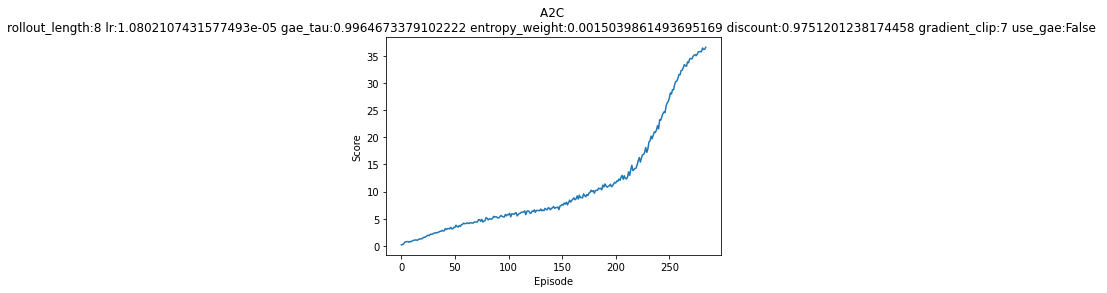

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
st = ''
for k in config.update_fields:
    st += '{}:{} '.format(k,best[k]) 
plt.title("A2C \n{}".format(st))
plt.show()

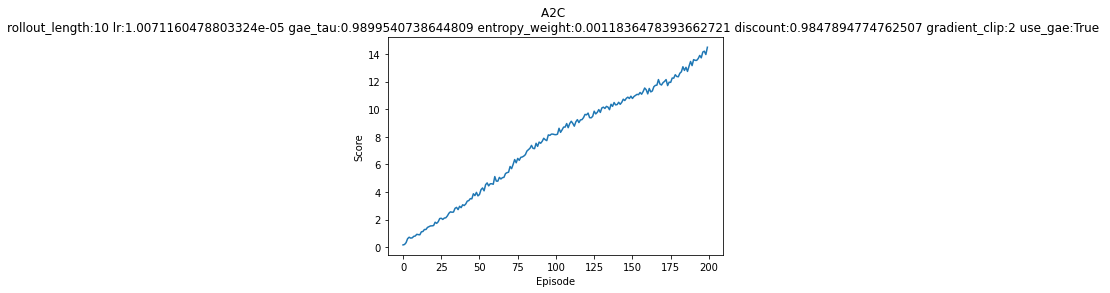

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
st = ''
for k in config.update_fields:
    st += '{}:{} '.format(k,best[k]) 
plt.title("A2C \n{}".format(st))
plt.show()

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
st = ''
for k in config.update_fields:
    st += '{}:{} '.format(k,best[k]) 
plt.title("A2C \n{}".format(st))
plt.show()

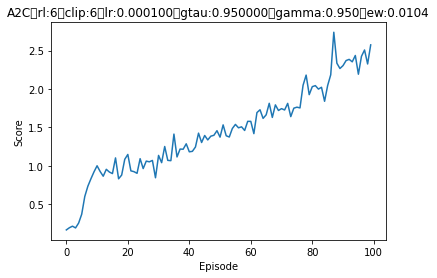

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title("A2C rl:{} clip:{} lr:{:.6f} gtau:{:.6f} gamma:{:.3f} ew:{:.4f}".format(
    config.rollout_length,
    config.gradient_clip,
    config.lr,
    config.gae_tau,
    config.discount,
    config.entropy_weight))
plt.show()

In [17]:
print('Best:{}'.format(best) , flush = True)  

Best:{'rollout_length': 2, 'discount': 0.9, 'gradient_clip': 1, 'lr': 1e-05, 'gae_tau': 0.9, 'entropy_weight': 0.0009}
